# Main quest1 Pneumonia detection

## Rubric:

### 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
    - 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
    
### 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
    - Regularization, Augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
    
### 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
    - Accuracy 기준 85%에 도달하였다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 실수 입력 시 내림하여 정수 반환
random.seed(2023)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))   
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지 구분이 필요
# 파일 경로를 통해 확인해보기
print(f'Normal image path\n{filenames[0]}')       #person531_virus_1053.jpeg
print(f'Pneumonia image path\n{filenames[2000]}') #NORMAL2-IM-0895-0001.jpeg

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person531_virus_1053.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0895-0001.jpeg


In [6]:
# 파일 경로에 Normal이 있는지 확인하여 정상 이미지의 수를 센다
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 pneuumonia가 있는지 확인하여 폐렴 이미지의 수를 센다
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


# 페렴 이미지 수가 3배 더 많음
# CNN은 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

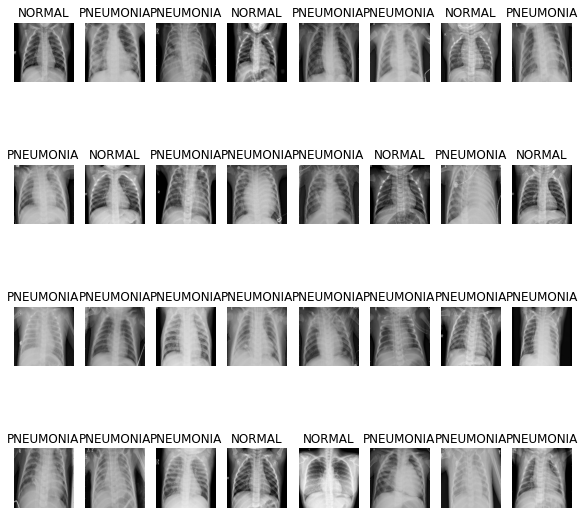

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Build vanilla model

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))      
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

# normal 의 데이터가 3배 적으므로, 3배 강하게 학습

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/50
130/130 [==============================] - 65s 399ms/step - loss: 0.3507 - accuracy: 0.8382 - precision: 0.9591 - recall: 0.8174 - val_loss: 0.6987 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/50
130/130 [==============================] - 52s 400ms/step - loss: 0.2018 - accuracy: 0.9281 - precision: 0.9778 - recall: 0.9245 - val_loss: 0.9016 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/50
130/130 [==============================] - 53s 406ms/step - loss: 0.1606 - accuracy: 0.9425 - precision: 0.9825 - recall: 0.9397 - val_loss: 1.1239 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/50
130/130 [==============================] - 54s 417ms/step - loss: 0.1518 - accuracy: 0.9442 - precision: 0.9805 - recall: 0.9437 - val_loss: 1.5068 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/50
130/130 [==============================] - 57s 438ms/step - loss: 0.1288 - accura

In [24]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
EPOCHS = 6

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)


with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/6
130/130 [==============================] - 61s 402ms/step - loss: 0.4004 - accuracy: 0.8224 - precision: 0.9612 - recall: 0.7931 - val_loss: 0.6104 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/6
130/130 [==============================] - 50s 385ms/step - loss: 0.2295 - accuracy: 0.9204 - precision: 0.9795 - recall: 0.9121 - val_loss: 0.8149 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/6
130/130 [==============================] - 51s 395ms/step - loss: 0.1663 - accuracy: 0.9438 - precision: 0.9829 - recall: 0.9411 - val_loss: 1.0600 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/6
130/130 [==============================] - 52s 403ms/step - loss: 0.1591 - accuracy: 0.9385 - precision: 0.9803 - recall: 0.9359 - val_loss: 1.3613 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/6
130/130 [==============================] - 53s 410ms/step - loss: 0.1588 - accuracy: 0

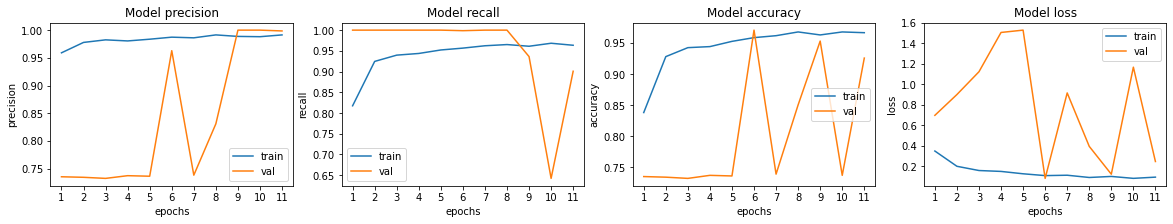

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history.history[met]) + 1)
    ax[i].plot(epochs, history.history[met])
    ax[i].set_xticks(range(1, len(history.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


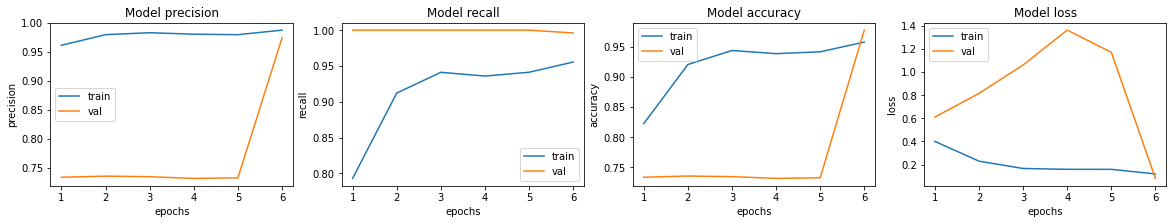

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history2.history[met]) + 1)
    ax[i].plot(epochs, history2.history[met])
    ax[i].set_xticks(range(1, len(history2.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 242ms/step - loss: 1.0077 - accuracy: 0.6971 - precision: 0.6736 - recall: 1.0000
Loss: 1.0077357292175293,
Accuracy: 0.6971153616905212,
Precision: 0.6735751032829285,
Recall: 1.0


In [27]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 225ms/step - loss: 0.7255 - accuracy: 0.7260 - precision: 0.6966 - recall: 0.9949
Loss: 0.7255126237869263,
Accuracy: 0.7259615659713745,
Precision: 0.6965888738632202,
Recall: 0.9948717951774597


## add skip connection 

In [20]:
def conv_block2(filters, input_tensor):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(input_tensor)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    input_tensor = tf.keras.layers.Conv2D(filters, 1)(input_tensor)
    x = tf.keras.layers.Add()([x, input_tensor])    # skip connection here
    x = tf.keras.layers.MaxPool2D()(x)
    
    return x

In [21]:
def dense_block2(units, dropout_rate, inputs):
    x = tf.keras.layers.Dense(units, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [22]:
def build_model2():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block2(32, x)
    x = conv_block2(64, x)
    
    x = conv_block2(128, x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block2(256, x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block2(512, 0.7, x)  
    x = dense_block2(128, 0.5, x)  
    x = dense_block2(64, 0.3, x)
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [54]:
with tf.device('/GPU:0'):
    model3 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [55]:
EPOCHS = 10

with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 65s 430ms/step - loss: 0.3829 - accuracy: 0.8002 - precision: 0.9546 - recall: 0.7680 - val_loss: 0.9593 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 51s 391ms/step - loss: 0.2331 - accuracy: 0.9062 - precision: 0.9737 - recall: 0.8982 - val_loss: 1.5857 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 51s 394ms/step - loss: 0.1781 - accuracy: 0.9361 - precision: 0.9794 - recall: 0.9339 - val_loss: 1.6218 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 52s 405ms/step - loss: 0.1508 - accuracy: 0.9474 - precision: 0.9813 - recall: 0.9474 - val_loss: 1.3991 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 53s 413ms/step - loss: 0.1449 - accura

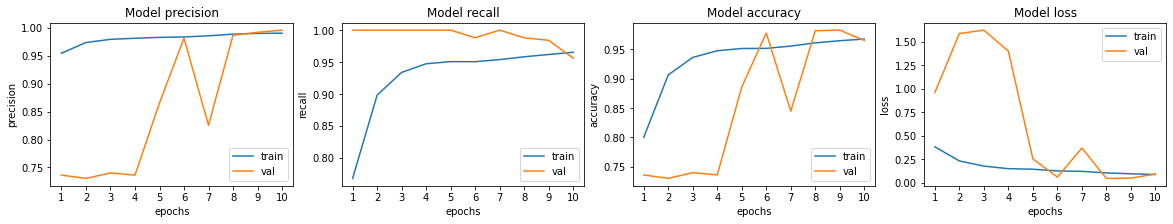

In [56]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history3.history[met]) + 1)
    ax[i].plot(epochs, history3.history[met])
    ax[i].set_xticks(range(1, len(history3.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [57]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 212ms/step - loss: 0.5675 - accuracy: 0.8157 - precision: 0.7871 - recall: 0.9667
Loss: 0.5674664378166199,
Accuracy: 0.8157051205635071,
Precision: 0.7870563864707947,
Recall: 0.9666666388511658


In [58]:
EPOCHS = 10 # +10

with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 58s 391ms/step - loss: 0.0776 - accuracy: 0.9719 - precision: 0.9937 - recall: 0.9683 - val_loss: 0.2470 - val_accuracy: 0.9131 - val_precision: 0.9970 - val_recall: 0.8843
Epoch 2/10
130/130 [==============================] - 50s 390ms/step - loss: 0.0807 - accuracy: 0.9702 - precision: 0.9908 - recall: 0.9690 - val_loss: 0.0457 - val_accuracy: 0.9844 - val_precision: 0.9959 - val_recall: 0.9827
Epoch 3/10
130/130 [==============================] - 52s 401ms/step - loss: 0.0801 - accuracy: 0.9695 - precision: 0.9917 - recall: 0.9671 - val_loss: 0.0373 - val_accuracy: 0.9863 - val_precision: 0.9920 - val_recall: 0.9894
Epoch 4/10
130/130 [==============================] - 53s 409ms/step - loss: 0.0620 - accuracy: 0.9755 - precision: 0.9944 - recall: 0.9726 - val_loss: 0.0562 - val_accuracy: 0.9824 - val_precision: 0.9829 - val_recall: 0.9934
Epoch 5/10
130/130 [==============================] - 54s 418ms/step - loss: 0.0593 - accura

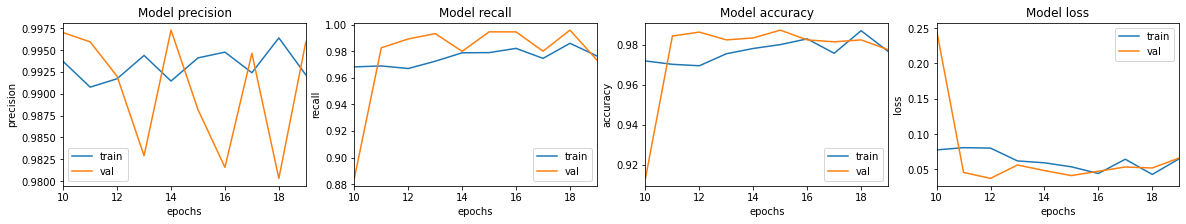

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(10, len(history3.history[met]) + 10)  # 에포크 인덱스에 10 더하기
    ax[i].plot(epochs, history3.history[met])
    ax[i].plot(epochs, history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_xlim([10, max(epochs)])  # x축의 시작점을 10으로 설정
    ax[i].legend(['train', 'val'])

plt.show()

In [60]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 222ms/step - loss: 0.6596 - accuracy: 0.8365 - precision: 0.8038 - recall: 0.9769
Loss: 0.6596316695213318,
Accuracy: 0.8365384340286255,
Precision: 0.8037974834442139,
Recall: 0.9769230484962463


## train data augementation -> train_ds_aug

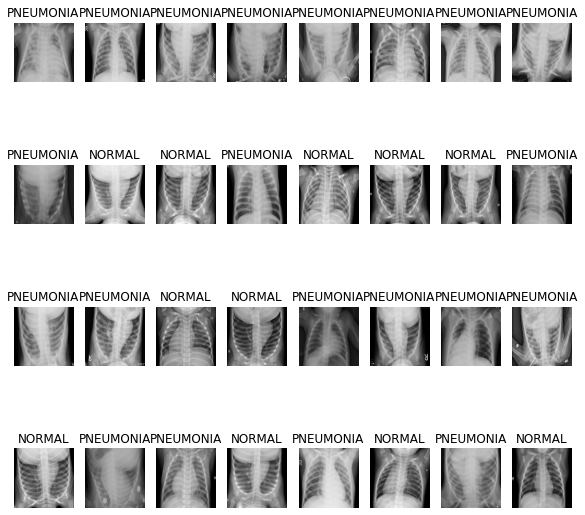

In [23]:
def augment1(image,label):
    
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
    
def augment2(image,label):
    
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전합니다.
    return image,label
    
def prepare_for_training2(ds, shuffle_buffer_size=1000):
        
    ds = ds.map(augment1,num_parallel_calls=2)
    ds = ds.map(augment2,num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() #epoch 횟수만큼 repeat
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) #학습 데이터 나눠서 읽어와 GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비
    return ds


train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    
train_ds_aug = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    
train_ds_aug = prepare_for_training2(train_ds_aug)

image_batch, label_batch = next(iter(train_ds_aug))
show_batch(image_batch.numpy(), label_batch.numpy())

## vanilla model + data augmentaion

In [69]:
with tf.device('/GPU:0'):
    model4 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [70]:
EPOCHS = 10

with tf.device('/GPU:0'):
    history4 = model4.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 61s 403ms/step - loss: 0.4326 - accuracy: 0.7971 - precision: 0.9497 - recall: 0.7682 - val_loss: 0.6535 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 51s 397ms/step - loss: 0.2569 - accuracy: 0.9038 - precision: 0.9680 - recall: 0.9003 - val_loss: 0.8757 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 52s 404ms/step - loss: 0.2294 - accuracy: 0.9151 - precision: 0.9715 - recall: 0.9130 - val_loss: 1.0752 - val_accuracy: 0.7402 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 53s 408ms/step - loss: 0.1837 - accuracy: 0.9377 - precision: 0.9797 - recall: 0.9357 - val_loss: 1.4411 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 54s 419ms/step - loss: 0.1769 - accura

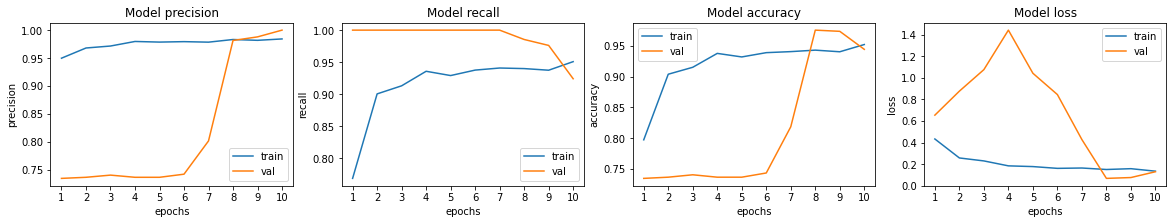

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history4.history[met]) + 1)
    ax[i].plot(epochs, history4.history[met])
    ax[i].set_xticks(range(1, len(history4.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [72]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 237ms/step - loss: 0.4030 - accuracy: 0.8478 - precision: 0.8406 - recall: 0.9333
Loss: 0.40298205614089966,
Accuracy: 0.8477563858032227,
Precision: 0.8406466245651245,
Recall: 0.9333333373069763


In [77]:
with tf.device('/GPU:0'):
    model5 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model5.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
EPOCHS = 9

with tf.device('/GPU:0'):
    history5 = model5.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/9
130/130 [==============================] - 62s 404ms/step - loss: 0.4449 - accuracy: 0.7837 - precision: 0.9455 - recall: 0.7523 - val_loss: 0.6171 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/9
130/130 [==============================] - 52s 401ms/step - loss: 0.2751 - accuracy: 0.8942 - precision: 0.9693 - recall: 0.8862 - val_loss: 0.8353 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 3/9
130/130 [==============================] - 52s 406ms/step - loss: 0.2026 - accuracy: 0.9233 - precision: 0.9769 - recall: 0.9184 - val_loss: 1.1737 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/9
130/130 [==============================] - 53s 412ms/step - loss: 0.1780 - accuracy: 0.9322 - precision: 0.9764 - recall: 0.9317 - val_loss: 1.6851 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/9
130/130 [==============================] - 54s 415ms/step - loss: 0.1574 - accuracy: 0

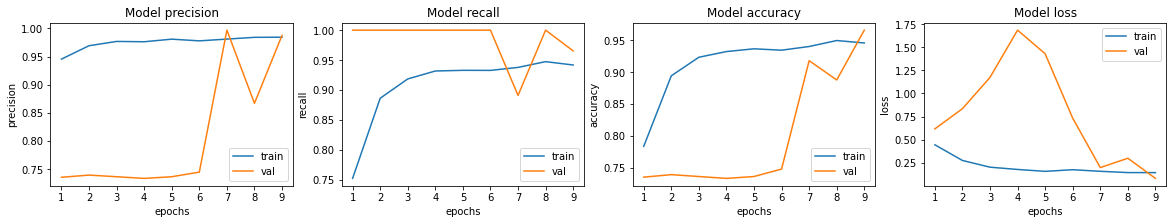

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history5.history[met]) + 1)
    ax[i].plot(epochs, history5.history[met])
    ax[i].set_xticks(range(1, len(history5.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [80]:
loss, accuracy, precision, recall = model5.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 211ms/step - loss: 0.4531 - accuracy: 0.8429 - precision: 0.8106 - recall: 0.9769
Loss: 0.4530964493751526,
Accuracy: 0.8429487347602844,
Precision: 0.8106383085250854,
Recall: 0.9769230484962463


## skip connection added model + data augmentaion

In [81]:
with tf.device('/GPU:0'):
    model6 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model6.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [82]:
EPOCHS = 10

with tf.device('/GPU:0'):
    history6 = model6.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 61s 397ms/step - loss: 0.4107 - accuracy: 0.7825 - precision: 0.9582 - recall: 0.7401 - val_loss: 0.5748 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 51s 395ms/step - loss: 0.2722 - accuracy: 0.8844 - precision: 0.9711 - recall: 0.8704 - val_loss: 0.9860 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 52s 399ms/step - loss: 0.2300 - accuracy: 0.9123 - precision: 0.9763 - recall: 0.9042 - val_loss: 1.3680 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 53s 408ms/step - loss: 0.1959 - accuracy: 0.9255 - precision: 0.9783 - recall: 0.9200 - val_loss: 1.2572 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 55s 422ms/step - loss: 0.1766 - accura

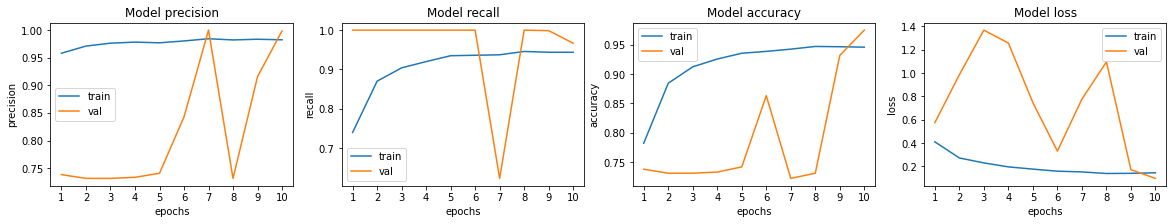

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history6.history[met]) + 1)
    ax[i].plot(epochs, history6.history[met])
    ax[i].set_xticks(range(1, len(history6.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history6.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [84]:
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 218ms/step - loss: 0.4196 - accuracy: 0.8173 - precision: 0.7887 - recall: 0.9667
Loss: 0.4196125566959381,
Accuracy: 0.817307710647583,
Precision: 0.7887029051780701,
Recall: 0.9666666388511658


In [85]:
EPOCHS = 10 # +10

with tf.device('/GPU:0'):
    history6 = model6.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/10
130/130 [==============================] - 59s 400ms/step - loss: 0.1331 - accuracy: 0.9478 - precision: 0.9842 - recall: 0.9450 - val_loss: 0.1438 - val_accuracy: 0.9463 - val_precision: 1.0000 - val_recall: 0.9271
Epoch 2/10
130/130 [==============================] - 52s 399ms/step - loss: 0.1164 - accuracy: 0.9555 - precision: 0.9867 - recall: 0.9533 - val_loss: 3.5571 - val_accuracy: 0.2715 - val_precision: 1.0000 - val_recall: 0.0080
Epoch 3/10
130/130 [==============================] - 53s 407ms/step - loss: 0.1438 - accuracy: 0.9440 - precision: 0.9834 - recall: 0.9404 - val_loss: 2.1475 - val_accuracy: 0.4248 - val_precision: 1.0000 - val_recall: 0.2178
Epoch 4/10
130/130 [==============================] - 54s 416ms/step - loss: 0.1226 - accuracy: 0.9522 - precision: 0.9853 - recall: 0.9500 - val_loss: 2.0050 - val_accuracy: 0.5107 - val_precision: 1.0000 - val_recall: 0.3347
Epoch 5/10
130/130 [==============================] - 55s 422ms/step - loss: 0.1230 - accura

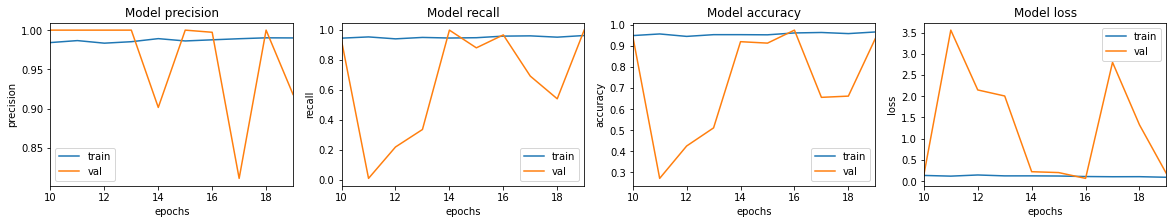

In [86]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(10, len(history6.history[met]) + 10)  # 에포크 인덱스에 10 더하기
    ax[i].plot(epochs, history6.history[met])
    ax[i].plot(epochs, history6.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_xlim([10, max(epochs)])  # x축의 시작점을 10으로 설정
    ax[i].legend(['train', 'val'])

plt.show()

In [87]:
loss, accuracy, precision, recall = model6.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 232ms/step - loss: 1.3502 - accuracy: 0.6763 - precision: 0.6588 - recall: 1.0000
Loss: 1.3502475023269653,
Accuracy: 0.6762820482254028,
Precision: 0.6587837934494019,
Recall: 1.0


## Scope best conditions

In [24]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy, precision, recall = self.model.evaluate(self.test_data)
        print(f'\nEpoch: {epoch+1}')
        print(f'Test Loss: {loss},\nTest Accuracy: {accuracy},\nTest Precision: {precision},\nTest Recall: {recall}\n')

In [93]:
with tf.device('/GPU:0'):
    model7 = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model7.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

    EPOCHS = 20
    test_callback = TestCallback(test_ds)

    history7 = model7.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[test_callback]
    )


Epoch 1/20
20/20 [==============================] - 5s 240ms/step - loss: 0.8954 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 1
Test Loss: 0.8953706622123718,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 2/20
20/20 [==============================] - 5s 218ms/step - loss: 1.5754 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 2
Test Loss: 1.57541823387146,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 3/20
20/20 [==============================] - 5s 235ms/step - loss: 1.7870 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 3
Test Loss: 1.7870241403579712,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 4/20
20/20 [==============================] - 5s 233ms/step - loss: 1.4940 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 4
Test Loss: 1.4940179586410522,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 5/20
20/20 [====================

20/20 [==============================] - 8s 387ms/step - loss: 1.2157 - accuracy: 0.7468 - precision: 0.7125 - recall: 0.9974

Epoch: 18
Test Loss: 1.215712070465088,
Test Accuracy: 0.7467948794364929,
Test Precision: 0.7124541997909546,
Test Recall: 0.9974358677864075

Epoch 19/20
20/20 [==============================] - 8s 397ms/step - loss: 0.4392 - accuracy: 0.8349 - precision: 0.8284 - recall: 0.9282

Epoch: 19
Test Loss: 0.439167857170105,
Test Accuracy: 0.8349359035491943,
Test Precision: 0.8283752799034119,
Test Recall: 0.928205132484436

Epoch 20/20
20/20 [==============================] - 8s 380ms/step - loss: 0.9961 - accuracy: 0.7340 - precision: 0.7036 - recall: 0.9923

Epoch: 20
Test Loss: 0.9960727095603943,
Test Accuracy: 0.7339743375778198,
Test Precision: 0.7036363482475281,
Test Recall: 0.9923076629638672



- Over 85% -> epoch 7, 9 

## Build model & stop when (test_acc > 85%)

    - Conv block with Skip connection
    - Augmented train data
    - Batch_size = 32

In [25]:
class TestCallback2(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy, precision, recall = self.model.evaluate(self.test_data)
        print(f'\nEpoch: {epoch+1}')
        print(f'Test Loss: {loss},\nTest Accuracy: {accuracy},\nTest Precision: {precision},\nTest Recall: {recall}\n')
        if accuracy >= 0.85:
            print("Test accuracy over 85%, stopping training")
            self.model.stop_training = True


In [26]:
with tf.device('/GPU:0'):
    best_model = build_model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    best_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    EPOCHS = 30
    test_callback = TestCallback2(test_ds)

    history8 = best_model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[test_callback]
    )

Epoch 1/30
20/20 [==============================] - 5s 250ms/step - loss: 1.2893 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 1
Test Loss: 1.2892849445343018,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 2/30
20/20 [==============================] - 5s 219ms/step - loss: 1.8114 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 2
Test Loss: 1.8113973140716553,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 3/30
20/20 [==============================] - 5s 229ms/step - loss: 1.8052 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 3
Test Loss: 1.8051611185073853,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 4/30
20/20 [==============================] - 4s 220ms/step - loss: 1.8771 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000

Epoch: 4
Test Loss: 1.8770992755889893,
Test Accuracy: 0.625,
Test Precision: 0.625,
Test Recall: 1.0

Epoch 5/30
20/20 [==================

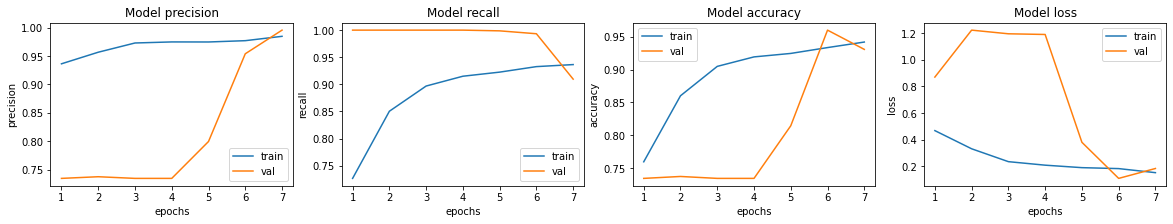

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    epochs = range(1, len(history8.history[met]) + 1)
    ax[i].plot(epochs, history8.history[met])
    ax[i].set_xticks(range(1, len(history8.history[met]) + 1))  # x축 눈금을 1부터 시작하도록 변경
    ax[i].plot(epochs, history8.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()


In [28]:
loss, accuracy, precision, recall = best_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 249ms/step - loss: 0.3627 - accuracy: 0.8782 - precision: 0.8774 - recall: 0.9359
Loss: 0.36265331506729126,
Accuracy: 0.8782051205635071,
Precision: 0.8774038553237915,
Recall: 0.9358974099159241


## Results

| model | Skip-connection | Data-Augmented | epoch | test_acc(%) |
|-------|-----------------|----------------|-------|-------------|
| 1     | X               | X              | 11    | 69.71       |
| 2     | X               | X              | 6     | 72.55       |
| 3-1   | O               | X              | 10    | 81.57       |
| 3-2   | O               | X              | 10+10 | 83.65       |
| 4     | X               | O              | 10    | 84.78       |
| 5     | X               | O              | 9     | 84.29       |
| 6-1   | O               | O              | 10    | 81.73       |
| 6-2   | O               | O              | 10+10 | 67.63       |
| 7     | O               | O              | Best at 9 | 87.82  |
| 8     | O               | O              | 7     | 87.82       |


#### With skip-connection model & data augmentation, accuracy for test data get higher

   - (test_accuracy > 85%) = True